# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose

## Загрузите данные и выполните их ресемплирование по одному часу.

Загрузим данные преобразовав тип столбца с датой и временем с object на datetime64 и назначим столбец индексами

In [2]:
try:
    df = pd.read_csv('taxi.csv', sep=',',index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем индексы и проверим в хронологическом ли порядке расположены даты и время

In [4]:
df = df.sort_index()
print(df.index.is_monotonic)

True


In [5]:
# выполним ресемпоирование по 1 часу 
df = df.resample('1H').sum()

В датасете отсутствуют пропуски, данные представлены двумя столбцами: время и количество заказов.
Хронология не нарушена.



## Проанализируйте данные. 

Построим график временного ряда

Text(0.5, 1.0, 'Заказы такси за все время')

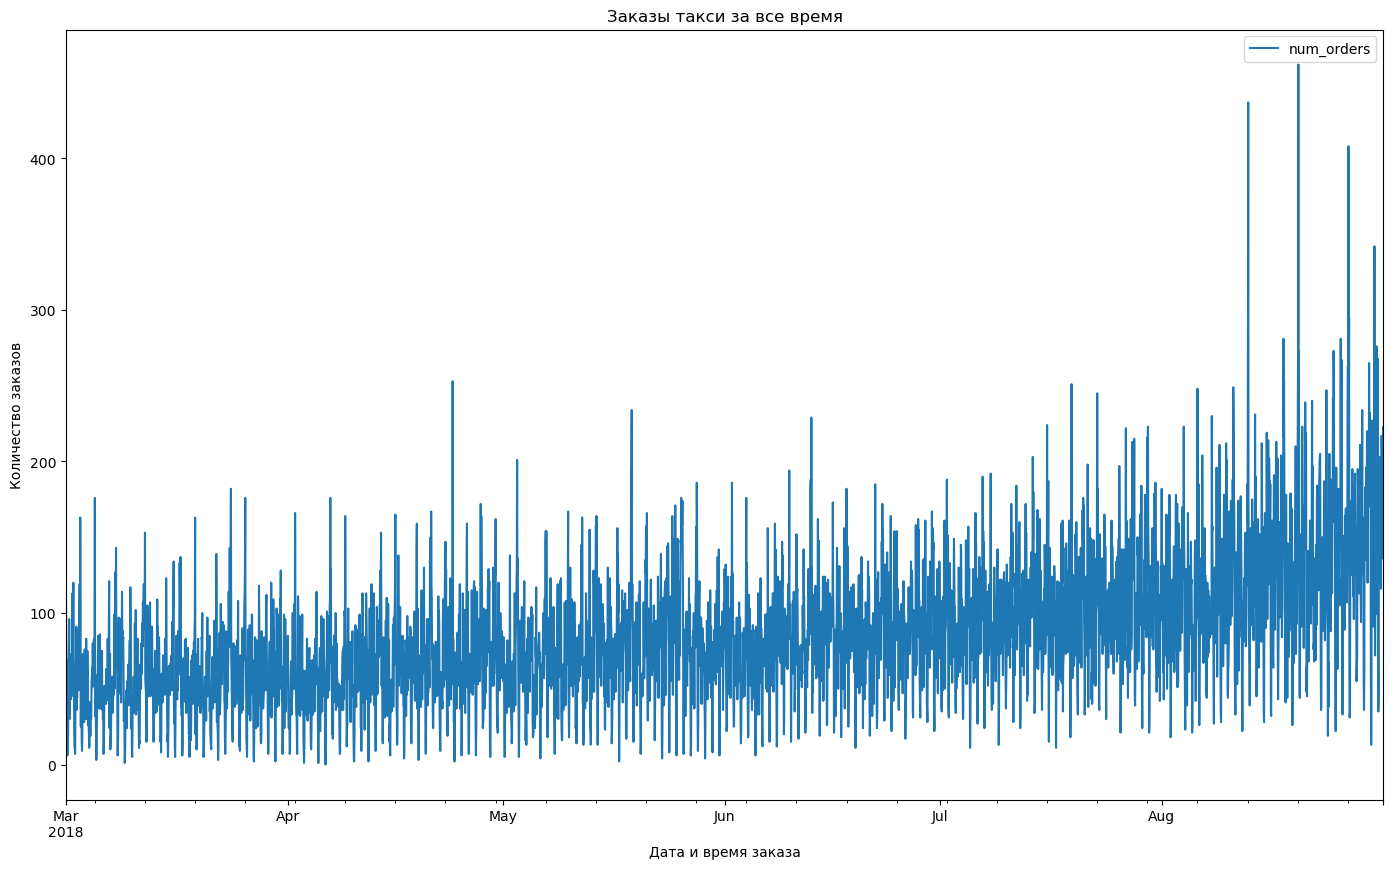

In [6]:
df.plot(figsize=(17, 10))
plt.ylabel("Количество заказов")
plt.xlabel("Дата и время заказа")
plt.title("Заказы такси за все время")

Мы видим,что число заказов со временем увеличивается - растет популярность такси или появляется узнаваемость компании.

In [7]:
# Изучим данные на сезонность и тренды
decomposed = seasonal_decompose(df) 
seasonal = decomposed.seasonal['2018-03-01':'2018-03-03']
trend = decomposed.trend['2018-03-01':'2018-08-31']
resid = decomposed.resid['2018-03-01':'2018-08-31']

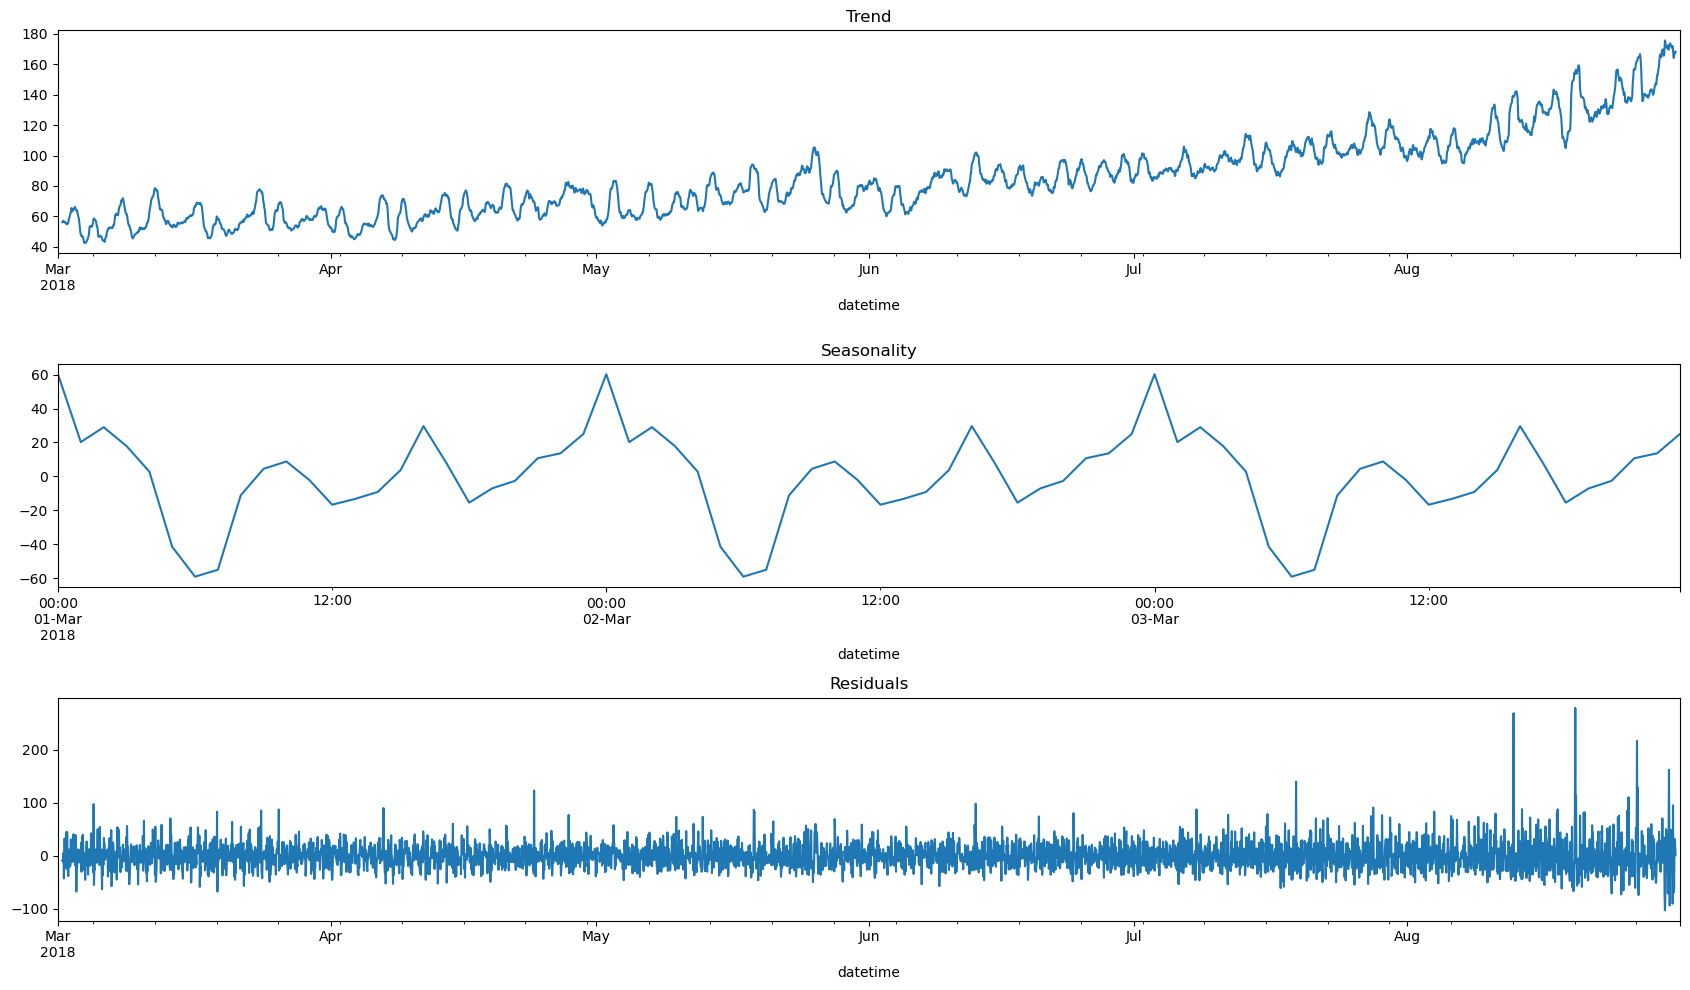

In [8]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
trend.plot(ax=plt.gca(), figsize=(17, 15))
plt.title('Trend')
plt.subplot(312)
seasonal.plot(ax=plt.gca(), figsize=(17, 10))
plt.title('Seasonality')
plt.subplot(313)
resid.plot(ax=plt.gca(), figsize=(17, 10))
plt.title('Residuals')
plt.tight_layout()

Наблюдается тренд на рост числа заказов. Присутствует ежедневная сезонность:пик нагрузки приходится на полночь, еще один пик, нопоменьше около 16.00 - 16.30 дня, минимальное число заказов около 06.00 утра.

Text(0.5, 1.0, 'Заказы такси за все время, скользящее среднее, стандартное отклонение')

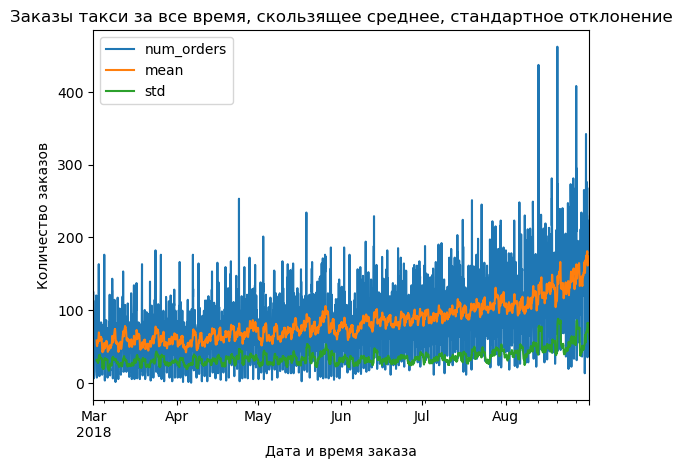

In [9]:
# Построим график с отображением скользящих среднего и стандартного отклонения.
df_stac = df.copy()
df_stac['mean'] = df_stac['num_orders'].rolling(30).mean()
df_stac['std'] = df_stac['num_orders'].rolling(30).std()
df_stac.plot() 
plt.ylabel("Количество заказов")
plt.xlabel("Дата и время заказа")
plt.title("Заказы такси за все время, скользящее среднее, стандартное отклонение")

Среднее и стандартное отклонение меняется - временной ряд нестационарный. Найдем разности его значений и снова посторим график

Text(0.5, 1.0, 'Заказы такси за все время, скользящее среднее, стандартное отклонение')

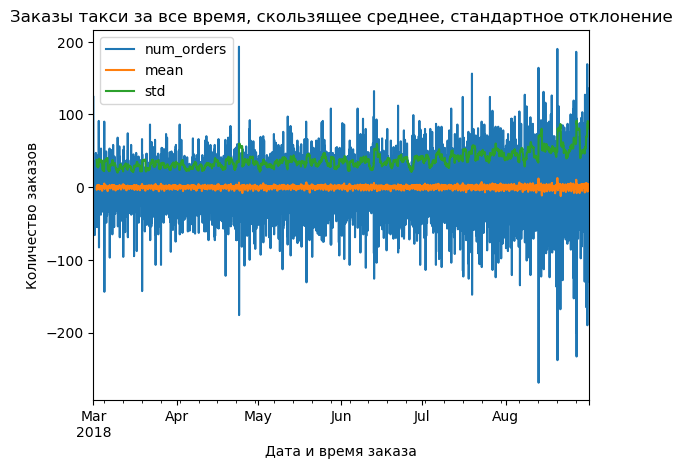

In [10]:
df_stac = df_stac - df_stac.shift(fill_value=0)
df_stac['mean'] = df_stac['num_orders'].rolling(30).mean()
df_stac['std'] = df_stac['num_orders'].rolling(30).std()
df_stac.plot()
plt.ylabel("Количество заказов")
plt.xlabel("Дата и время заказа")
plt.title("Заказы такси за все время, скользящее среднее, стандартное отклонение")

Разности ряда более стационарны.

Не очень понимаю, что надо сказать) Может то, что нестационарные ряды хуже прогнозировать из-за их быстро меняющихся свойств, а среднее и стандартное отклонение более стационарного ряда меняется медленнее, поэтому для более точного прогноза добавим в признаки скользящие среднее и стд отклонение со сдвигом

## Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных. 

Создадим признаки для прогнозирования 

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
   
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    return

In [12]:
#Подберем лаги и размер окна скользящего среднего
make_features(df, 168, 100)
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Удалим пропуски
df = df.dropna()

In [14]:
# Поделим данные на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Данные поделены и готовы к обучению.
Обучим LinearRegression, CatBoostRegressor, Ridge, Lasso.

In [15]:
tscv = TimeSeriesSplit(n_splits=3)

# Строим LinearRegression и обучаем
params_lr = {}
model_lr = RandomizedSearchCV(LinearRegression(), params_lr, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=12345, cv=tscv, verbose=10)
model_lr.fit(features_train, target_train)

# Определяем лучяший результат и его гиперпараметры
display(model_lr.best_params_)
display(model_lr.best_score_*-1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{}

23.682349346011268

RMSE LR = 23.682

In [16]:
# Строим CatBoostRegressor
params_cbr = {
    'learning_rate': [0.01, 0.1],
    'depth': [None] + [i for i in range(2, 12)],
    'n_estimators': [i for i in range(50, 100)]
}


model_cbr = RandomizedSearchCV(CatBoostRegressor(random_state=12345), params_cbr, n_iter=10, scoring='neg_root_mean_squared_error', random_state=12345, n_jobs=-1, cv=tscv, verbose=10)

# Обучаем CatBoostRegressor
model_cbr.fit(features_train, target_train)
# Определяем лучяший результат и его гиперпараметры
display(model_cbr.best_params_)
display(model_cbr.best_score_*-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 36.7417658	total: 185ms	remaining: 15s
1:	learn: 34.9212561	total: 200ms	remaining: 7.99s
2:	learn: 33.4018946	total: 209ms	remaining: 5.49s
3:	learn: 32.0268972	total: 217ms	remaining: 4.23s
4:	learn: 30.7842262	total: 227ms	remaining: 3.49s
5:	learn: 29.6786426	total: 236ms	remaining: 2.99s
6:	learn: 28.6872435	total: 245ms	remaining: 2.62s
7:	learn: 27.8114402	total: 254ms	remaining: 2.35s
8:	learn: 26.9358933	total: 263ms	remaining: 2.13s
9:	learn: 26.2800649	total: 273ms	remaining: 1.96s
10:	learn: 25.6887964	total: 282ms	remaining: 1.82s
11:	learn: 25.1304786	total: 291ms	remaining: 1.7s
12:	learn: 24.7354818	total: 299ms	remaining: 1.59s
13:	learn: 24.2896603	total: 308ms	remaining: 1.5s
14:	learn: 23.9605505	total: 316ms	remaining: 1.41s
15:	learn: 23.6648720	total: 325ms	remaining: 1.34s
16:	learn: 23.3690415	total: 334ms	remaining: 1.28s
17:	learn: 23.1024904	total: 345ms	remaining: 1.23s
18:	learn: 22.875

{'n_estimators': 82, 'learning_rate': 0.1, 'depth': 4}

23.497639038875047

Параметры для CBR: n_estimators = 82, learning_rate = 0.1, depth = 4.
RMSE CatB = 23.497639

In [17]:
# Строим Ridge
params_r = {"alpha":[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
model_r = RandomizedSearchCV(Ridge(random_state=12345), params_r, n_iter=10, scoring='neg_root_mean_squared_error', random_state=12345, n_jobs=-1, cv=tscv, verbose=10)
model_r.fit(features_train, target_train)
# Определяем лучяший результат и его гиперпараметры
display(model_r.best_params_)
display(model_r.best_score_*-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'alpha': 20}

23.674870022025903

Параметры для Ridge: alpha = 20. 
RMSE Ridge = 23.67487

In [18]:
# Строим Lasso
params_las = {"alpha":[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
model_las = RandomizedSearchCV(Lasso(random_state=12345), params_las, n_iter=10, scoring='neg_root_mean_squared_error', random_state=12345, n_jobs=-1, cv=tscv, verbose=10)
model_las.fit(features_train, target_train)
# Определяем лучяший результат и его гиперпараметры
display(model_las.best_params_)
display(model_las.best_score_*-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'alpha': 20}

22.468059416376473

Параметры для Lasso: alpha = 20. RMSE Lasso = 22.468059

Лучший результат показала модель Lasso, выбираем ее для тестирования.

## Проверьте данные на тестовой выборке и сделайте выводы.

Сделаем проверку лучшей модели на тестовой выборке.

In [19]:
model_las = Lasso(alpha=20)
model_las.fit(features_train, target_train)
predictions = model_las.predict(features_test)
                                
print('RMSE Lasso:', mean_squared_error(target_test, predictions)**0.5)

RMSE Lasso: 34.36497277382239


RMSE Lasso = 34.36497

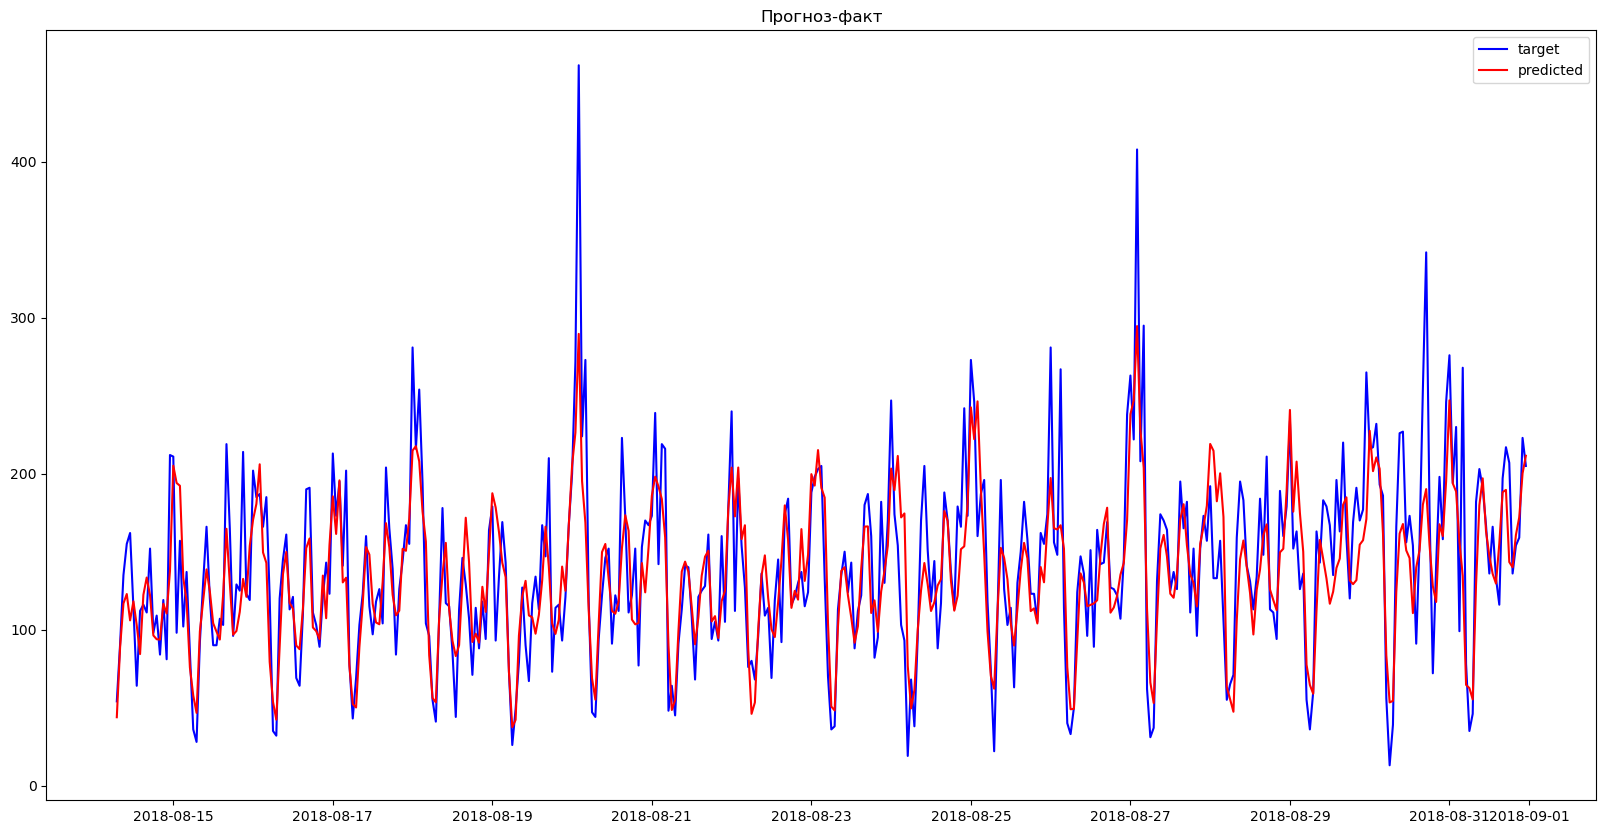

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(target_test.index,target_test,'b-', label = "target")
plt.plot(target_test.index, predictions, 'r-', label = "predicted")
plt.title("Прогноз-факт")
plt.legend()
plt.show()

Модель предсказывает большинство значений правильно, ондако на пиковых нагрузках не попадает в цель.

    Вывод:
    Была проведена загрузка и подготовка данных, добавлены новые признаки для прогнозирования.
    Во время анализа был замечен тренд на увеличение заказов такси, который вероятно вызван ростом компании и ее узнаваемости. 
    Также была отмечена суточная сезонность.Пик нагрузки приходится на полночь, еще один пик, но поменьше около 16.00 - 16.30 дня, минимальное число заказов около 06.00 утра.
    Были обучены модели для прогнозирования количества заказов такси на следующий час с подбором гиперпараметров. Наилучший результат показала модель Lasso. Её RMSE на обучающей выборке = 22.468059,  RMSE на тестовой = 34.36497.